In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from scipy.stats import poisson
from scipy.optimize import minimize
from dataclasses import dataclass

In [2]:
@dataclass
class Team:
    '''
    stores some basic information about a team
    '''
    name: str
    attack: float
    defence: float

@dataclass
class Settings:
    '''
    store the settings (hyperparameters) used
    sd_movement = sd of change in team abilities between seasons
        (higher -> team ratings are allowed to change more between seasons)
    '''
    sd_movement: float
    h_adv_init: float

In [3]:
def make_date(datestr: str) -> date:
    '''
    reformat date string DD/MM/YYYY into datetime date
    '''
    info = datestr.split("/")
    day = int(info[0])
    month = int(info[1])
    year = int(info[2])
    return date(year, month, day)

def calculate_season(date: date) -> int:
    '''
    figure out what season we are in (2023/24 season is called 2024, etc)
    '''
    if date.month >= 7:
        return date.year
    return date.year - 1



def gather_matches(match_data: pd.DataFrame, team_idx: dict) -> np.ndarray:
    '''
    takes a dataframe of matches and converts it into a np array with just basic information
    output: array of tuples of matches (home index, away index, home goals, away goals)
    '''
    match_data = match_data.copy()
    match_data["h_idx"] = match_data["HomeTeam"].apply(lambda x: team_idx[x])
    match_data["a_idx"] = match_data["AwayTeam"].apply(lambda x: team_idx[x])

    match_data = match_data[["h_idx", "a_idx", "FTHG", "FTAG"]]
    matches = [tuple(i) for i in match_data.itertuples(index=False, name=None)]

    return np.array(matches)

def neg_log_season(theta: np.ndarray, matches_array: np.ndarray, n_teams: int) -> float:
    '''
    calculates the negative log likelihood of a season, given attack, defence, home adv ratings
    vectorised for decent performance. for loops would be very slow
    '''
    attacks = theta[:n_teams]
    defences = theta[n_teams:2*n_teams]
    home_adv = theta[-1]

    attacks = attacks - np.mean(attacks)  # identifiability by enforcing attacks mean=0

    h_idx = matches_array[:, 0].astype(int)
    a_idx = matches_array[:, 1].astype(int)
    h_goals = matches_array[:, 2].astype(int)
    a_goals = matches_array[:, 3].astype(int)

    # calculate lambda param for home and away poisson distributinos
    lam_h = np.exp(home_adv + attacks[h_idx] - defences[a_idx])
    lam_h = np.clip(lam_h, 1e-10, 1e2)  # prevent underflow / overflow (usually unnecessary)

    lam_a = np.exp(-home_adv + attacks[a_idx] - defences[h_idx])
    lam_a = np.clip(lam_a, 1e-10, 1e2)  # prevent underflow / overflow (usually unnecessary)

    # calculate log likelihood
    log_like = poisson.logpmf(h_goals, lam_h) + poisson.logpmf(a_goals, lam_a)
    return -np.sum(log_like)


def p_total_over(goals: float, home_team: Team, away_team: Team, home_adv: float) -> float:
    '''
    calculates the probability of the total goals in a match exceeding some number
    '''
    lam_h = np.exp(home_adv + home_team.attack - away_team.defence)
    lam_a = np.exp(-home_adv + away_team.attack - home_team.defence)
    lam = lam_h + lam_a
    prob = 1 - poisson.cdf(np.floor(goals), lam)
    return prob

def p_over(goals: float, home_team: Team, away_team: Team, home_adv: float, home_or_away: str) -> float:
    '''
    calculates the probability of one team's goals in a match exceeding some number
    '''
    if home_or_away == "home":
        lam = np.exp(home_adv + home_team.attack - away_team.defence)
        return 1 - poisson.cdf(np.floor(goals), lam)
    lam = np.exp(-home_adv + away_team.attack - home_team.defence)
    return 1 - poisson.cdf(lam, np.floor(goals))

def log_likelihood(big_theta: np.ndarray, seasons: dict, n_teams: int, settings: Settings) -> float:

    '''
    big log likelihood function
    '''
    # take theta and break it into components (season by seasons ratings + home adv)
    unique_seasons = list(seasons.keys())
    n_seasons = len(unique_seasons)
    thetas=dict()
    home_adv = big_theta[-1]
    for season in range(n_seasons):
        curr_theta = big_theta[2*n_teams*season:2*n_teams*(season+1)]
        curr_theta = np.append(curr_theta, home_adv)
        thetas[unique_seasons[season]] = curr_theta

    # for each season, calculate (negative) log-likelihood and add to total
    nll = 0
    for season in seasons.keys():
        matches = seasons[season]
        theta = thetas[season]
        nll += neg_log_season(theta=theta, matches_array=matches, n_teams=n_teams)


    # now calculate nll of change in rating between seasons
    # stack all season ratings into array (n_seasons, n_teams)
    attack_ratings = np.stack([big_theta[2*n_teams*season:2*n_teams*season + n_teams] for season in range(n_seasons)], axis=0)
    defence_ratings = np.stack([big_theta[2*n_teams*season + n_teams : 2*n_teams*(season+1)] for season in range(n_seasons)], axis=0)

    # find differences across seasons
    attack_diffs = attack_ratings[1:] - attack_ratings[:-1]  # shape (n_seasons-1, n_teams)
    defence_diffs = defence_ratings[1:] - defence_ratings[:-1]

    # log-likelihood contribution from random walk
    sd = settings.sd_movement
    n = n_seasons - 1

    # vectorised
    rw_ll = -0.5 * n * np.log(2*np.pi) - n * np.log(sd) - np.sum(attack_diffs**2) / (2*sd**2)
    rw_ll += -0.5 * n * np.log(2*np.pi) - n * np.log(sd) - np.sum(defence_diffs**2) / (2*sd**2)

    # subtract because function returns nll
    nll -= rw_ll
    return nll

def theta_to_df(big_theta: np.ndarray, season_matches: dict, teams: list, n_teams: int) -> pd.DataFrame:
    """
    Convert flat theta vector into a DataFrame of team ratings per season using preprocessed data.

    Parameters
    ----------
    big_theta : np.ndarray
        Flat array containing all attack/defence ratings for all seasons + home_adv at the end
    season_matches : dict
        Dictionary mapping season -> np.ndarray of matches (h_idx, a_idx, h_goals, a_goals)
    teams : list of str
        List of team names in order corresponding to indices in theta
    n_teams : int
        Number of teams

    Returns
    -------
    pd.DataFrame
        Columns: ["Season", "Team", "Attack", "Defence"]
        Plus a final row for home advantage
    """
    home_adv = big_theta[-1]
    rows = []

    # Sort seasons so theta slices match
    sorted_seasons = sorted(season_matches.keys())
    n_seasons = len(sorted_seasons)

    for season_idx, season in enumerate(sorted_seasons):
        # slice out season-specific parameters
        season_theta = big_theta[2*n_teams*season_idx : 2*n_teams*(season_idx+1)]
        attacks = season_theta[:n_teams]
        defences = season_theta[n_teams:2*n_teams]

        # optional: mean-zero attacks for identifiability
        attacks = attacks - np.mean(attacks)

        for i, team in enumerate(teams):
            rows.append({
                "Season": season,
                "Team": team,
                "Attack": attacks[i],
                "Defence": defences[i]
            })

    # Add home advantage row
    rows.append({
        "Season": "All",
        "Team": "HomeAdv",
        "Attack": home_adv,
        "Defence": np.nan
    })

    df = pd.DataFrame(rows)
    return df


def backtest(df_ratings: pd.DataFrame, match_data: pd.DataFrame, init_pnl: float =0):
    '''
    a backtest that uses attacking/defensive ratings and match data to bet on
    over/under 2.5 goals, using Bet365 odds as our book
    omniscient in that it uses ratings that were probably calculated using future data
    this makes it slightly unrealistic, and real returns may not be as good, if positive at all!

    this function is not very optimised, so takes a few seconds to run. could be optimised if needed
    '''
    money = init_pnl
    n_bets = 0
    dates = []
    pnl = []

    # get the home advantage from the df
    home_adv = df_ratings.loc[df_ratings["Team"]=="HomeAdv", "Attack"].iloc[0]
    for _, match in match_data.iterrows():
        # get important information about the match
        season = match["Season"]
        date = match["Date"]
        curr_ratings = df_ratings[df_ratings["Season"]==season]

        # get important information about the teams
        h_name = match["HomeTeam"]
        h_att = curr_ratings.loc[curr_ratings["Team"]==h_name, "Attack"].iloc[0]
        h_def = curr_ratings.loc[curr_ratings["Team"]==h_name, "Defence"].iloc[0]

        a_name = match["AwayTeam"]
        a_att = curr_ratings.loc[curr_ratings["Team"]==a_name, "Attack"].iloc[0]
        a_def = curr_ratings.loc[curr_ratings["Team"]==a_name, "Defence"].iloc[0]

        # package the teams into Team dataclass
        home_team = Team(h_name, h_att, h_def)
        away_team = Team(a_name, a_att, a_def)

        # check if the over bet is underpriced, if it is, bet
        fair = 1/p_total_over(2.5, home_team=home_team, away_team=away_team, home_adv=home_adv)
        odds = match["B365>2.5"]
        if fair < odds:

            total = match["FTHG"] + match["FTAG"]
            if total > 2.5:
                money += odds - 1
            else:
                money -= 1
            

        # check if the under bet is underpriced, if it is, bet
        fair = 1/(1-1/fair)
        odds = match["B365<2.5"]
        if fair < odds:
            total = match["FTHG"] + match["FTAG"]
            if total < 2.5:
                money += odds - 1
            else:
                money -= 1
        pnl.append(money)
        dates.append(date)

    df = pd.DataFrame({
        "pnl": pnl,
        "date": dates
    })
    return df

def fit_params(season_matches, n_teams, n_seasons, settings, teams):
    theta0 = np.zeros(2*n_seasons*n_teams + 1)
    theta0[-1] = settings.h_adv_init

    res=minimize(
        fun=log_likelihood,
        x0=theta0,
        args=(season_matches,n_teams,settings),
        method="L-BFGS-B"
    )
    ratings=res.x
    ratings = theta_to_df(ratings, season_matches, teams, n_teams)
    return ratings

def fit_and_backtest(match_data: pd.DataFrame, settings: Settings, team_idx: dict, test_begin: date, test_end: date, init_pnl: float=0):
    '''
    fit up to certain date,
    backtest after that date until test_end
    test end should be in the same season as test_begin
    '''
    teams = list(team_idx.keys())
    n_teams = len(team_idx)

    match_data = match_data.copy()
    train = match_data[match_data["Date"] < test_begin]
    test = match_data[(match_data["Date"] >= test_begin) & (match_data["Date"] <= test_end)]
    seasons = dict(tuple(train.groupby("Season")))
    season_matches = {season: gather_matches(df, team_idx)
                      for season, df in seasons.items()}
    n_seasons = len(seasons)
    print(f"fitting paramaters on data up to {test_begin}")
    ratings = fit_params(season_matches, n_teams, n_seasons, settings, teams)
    print(f"testing params on data from {test_begin} until {test_end}")
    results = backtest(ratings, test, init_pnl)
    final_pnl = results.iloc[-1]["pnl"]
    net = final_pnl-init_pnl
    print(f"in this period we made net ${net:.2f}\n")
    return results, final_pnl



In [16]:
'''
preprocessing and formatting work
'''

match_data = pd.read_csv("EPL.csv")
match_data["Date"] = match_data["Date"].apply(make_date)            # reformat date

match_data["Season"] = match_data["Date"].apply(calculate_season)   # figure out what season we're in

match_data.sort_values(by="Date",inplace=True)                      # sort data by date
match_data = match_data.reset_index(drop=True)

# Get unique teams from BOTH home and away
home_teams = set(match_data["HomeTeam"].unique())
away_teams = set(match_data["AwayTeam"].unique())
teams = sorted(list(home_teams | away_teams))  # Union of both sets
team_idx = {j:i for i,j in enumerate(teams)}

n_teams = len(team_idx)


seasons = dict(tuple(match_data.groupby("Season"))) # split the data into seasons
n_seasons = len(seasons)

season_matches = {                                  # group the data into seasons and make them lists of tuples for vectorisation
    season: gather_matches(df, team_idx)
    for season, df in seasons.items()
}

settings=Settings(0.1,0.1)

In [30]:
def second_half_backtest(match_data, settings, team_idx, first, last):
    mylist=[]
    pnl=0
    for year in range(first,last+1):
        start = date(year, 1, 1)
        end = date(year,6,30)
        results, pnl = fit_and_backtest(match_data, settings, team_idx, start, end, pnl)
        mylist.append(results)
    final = pd.concat(mylist)
    return final

In [ ]:

point1 = second_half_backtest(match_data, Settings(0.1,0.1), team_idx, 2019, 2026)
point2 = second_half_backtest(match_data, Settings(0.2,0.1), team_idx, 2019, 2026)
point3 = second_half_backtest(match_data, Settings(0.3,0.1), team_idx, 2018, 2026)

In [23]:
mylist = []
pnl=0
for year in range(2019,2027):
    start = date(year, 1, 1)
    end = date(year,6,30)
    results, pnl = fit_and_backtest(match_data, settings, team_idx, start, end, pnl)
    mylist.append(results)
final = pd.concat(mylist)
final

fitting paramaters on data up to 2019-01-01
testing params on data from 2019-01-01 until 2019-06-30
in this period we made net $12.49

fitting paramaters on data up to 2020-01-01
testing params on data from 2020-01-01 until 2020-06-30
in this period we made net $30.12

fitting paramaters on data up to 2021-01-01
testing params on data from 2021-01-01 until 2021-06-30
in this period we made net $12.04

fitting paramaters on data up to 2022-01-01
testing params on data from 2022-01-01 until 2022-06-30
in this period we made net $13.51

fitting paramaters on data up to 2023-01-01
testing params on data from 2023-01-01 until 2023-06-30
in this period we made net $18.26

fitting paramaters on data up to 2024-01-01
testing params on data from 2024-01-01 until 2024-06-30
in this period we made net $30.21

fitting paramaters on data up to 2025-01-01
testing params on data from 2025-01-01 until 2025-06-30
in this period we made net $-0.62

fitting paramaters on data up to 2026-01-01
testing par

,pnl,date
0,0.95,2019-01-01
1,2.07,2019-01-01
2,3.31,2019-01-01
3,4.59,2019-01-02
4,5.78,2019-01-02
...,...,...
38,123.13,2026-01-24
39,122.13,2026-01-25
40,122.13,2026-01-25
41,122.13,2026-01-25


In [24]:
final=pd.concat(mylist)

In [29]:
match_data[match_data["Date"]>=date(2026,1,1)]

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA,Season
2846,E0,2026-01-01,17:30,Crystal Palace,Fulham,1,1,D,1,0,...,1.95,1.96,1.96,1.91,1.95,1.88,1.90,2.02,1.95,2025
2847,E0,2026-01-01,17:30,Liverpool,Leeds,0,0,D,0,0,...,2.05,1.82,2.13,1.77,2.07,1.74,2.05,1.84,2.16,2025
2848,E0,2026-01-01,20:00,Sunderland,Man City,0,0,D,0,0,...,1.98,1.89,2.04,1.93,1.98,1.86,1.92,1.92,2.06,2025
2849,E0,2026-01-01,20:00,Brentford,Tottenham,0,0,D,0,0,...,2.08,1.82,2.13,1.80,2.08,1.74,2.02,1.83,2.19,2025
2850,E0,2026-01-03,17:30,Bournemouth,Arsenal,2,3,A,1,1,...,1.93,2.01,1.92,2.07,1.93,1.98,1.81,2.06,1.93,2025
2851,E0,2026-01-03,15:00,Wolves,West Ham,3,0,H,3,0,...,1.93,1.96,1.96,1.93,1.93,1.89,1.88,1.97,2.02,2025
2852,E0,2026-01-03,12:30,Aston Villa,Nott'm Forest,3,1,H,1,0,...,1.93,1.97,1.95,1.93,1.95,1.86,1.88,1.97,2.02,2025
2853,E0,2026-01-03,15:00,Brighton,Burnley,2,0,H,1,0,...,1.83,2.08,1.85,2.03,1.90,1.94,1.83,2.12,1.88,2025
2854,E0,2026-01-04,12:30,Leeds,Man United,1,1,D,0,0,...,1.85,1.99,1.93,2.00,1.87,1.94,1.82,2.05,1.94,2025
2855,E0,2026-01-04,15:00,Everton,Brentford,2,4,A,0,1,...,1.78,2.16,1.79,2.10,1.78,2.05,1.74,2.16,1.85,2025


In [25]:
x = final["date"]
y = final["pnl"]

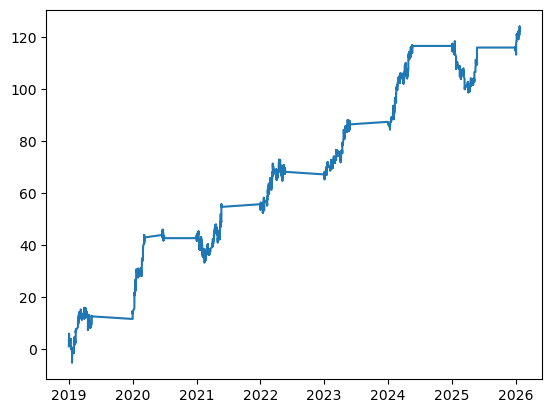

In [26]:
plt.plot(x,y)